**Importing Libraries**

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import backend, Model, models
from tensorflow.keras.applications import ResNet152V2, VGG19
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, Input, InputLayer, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from tensorflow.keras.regularizers import L2
from tensorflow.math import argmax, confusion_matrix, exp
from google.colab.patches import cv2_imshow
import cv2
from tensorflow import keras

from tensorflow.keras.metrics import AUC, Accuracy, CategoricalAccuracy

import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


# Useful functions
def reset_environment():
  # Clear the session
  backend.clear_session()

  # Reset the random seeds.
  os.environ['PYTHONHASHSEED']=str(1)
  tf.random.set_seed(1)
  np.random.seed(1)


# Load ResNet
reset_environment()

resnet_base = ResNet152V2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3))

resnet_base.trainable = False


# Define directory for saving models
models_dir = '/content/drive/MyDrive/Alzheimers_Dataset'

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

**Mounting Drive**

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset**

Train Mild: 717
Train Moderate: 52
Train Non: 2560
Train Very Mild: 1792
Test Mild: 179
Test Moderate: 12
Test Non: 640
Test Very Mild: 448


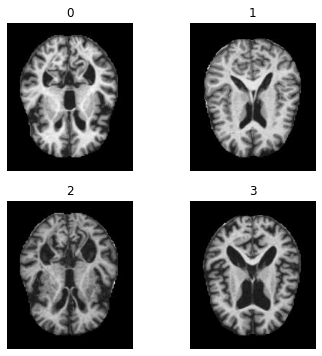

In [ ]:
# Explore dataset
base_dir = '/content/drive/MyDrive/Alzheimers_Dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_mild_dir = os.path.join(train_dir, 'MildDemented')
train_moderate_dir = os.path.join(train_dir, 'ModerateDemented')
train_non_dir = os.path.join(train_dir, 'NonDemented')
train_verymild_dir = os.path.join(train_dir, 'VeryMildDemented')

print('Train Mild:', len(os.listdir(train_mild_dir)))
print('Train Moderate:', len(os.listdir(train_moderate_dir)))
print('Train Non:', len(os.listdir(train_non_dir)))
print('Train Very Mild:', len(os.listdir(train_verymild_dir)))

test_mild_dir = os.path.join(test_dir, 'MildDemented')
test_moderate_dir = os.path.join(test_dir, 'ModerateDemented')
test_non_dir = os.path.join(test_dir, 'NonDemented')
test_verymild_dir = os.path.join(test_dir, 'VeryMildDemented')

print('Test Mild:', len(os.listdir(test_mild_dir)))
print('Test Moderate:', len(os.listdir(test_moderate_dir)))
print('Test Non:', len(os.listdir(test_non_dir)))
print('Test Very Mild:', len(os.listdir(test_verymild_dir)))


# Display sample images
path1 = os.path.join(train_non_dir, os.listdir(train_non_dir)[0])
path2 = os.path.join(train_verymild_dir, os.listdir(train_verymild_dir)[0])
path3 = os.path.join(train_mild_dir, os.listdir(train_mild_dir)[0])
path4 = os.path.join(train_moderate_dir, os.listdir(train_moderate_dir)[0])

img1 = image.load_img(path1)
img2 = image.load_img(path2)
img3 = image.load_img(path3)
img4 = image.load_img(path4)

images = [
    img1,
    img2,
    img3,
    img4
]

def plot_images(images):
    fig = plt.figure(figsize=(6, 6))
    
    i = 1
    for image in images:
        fig.add_subplot(2, 2, i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(i-1)
        i += 1

        
plot_images(images)

**Training and Evaluation**

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/40
200/200 [==============================] - 22s 104ms/step - loss: 0.9534 - accuracy: 0.6351 - val_loss: 6.6965 - val_accuracy: 0.1380 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 17s 87ms/step - loss: 0.4680 - accuracy: 0.8194 - val_loss: 1.0393 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 17s 86ms/step - loss: 0.2796 - accuracy: 0.8917 - val_loss: 1.3327 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 17s 85ms/step - loss: 0.2068 - accuracy: 0.9267 - val_loss: 4.2362 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 17s 86ms/step - loss: 0.1871 - accuracy: 0.9295 - val_loss: 2.1037 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 18s 88ms/step - loss: 0.0755 - acc

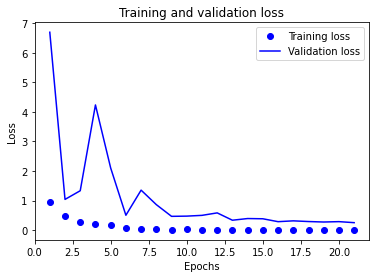

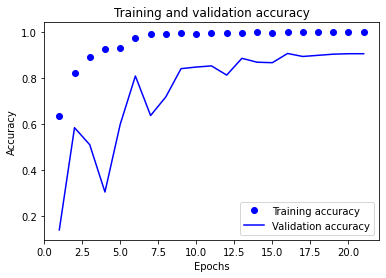

50/50 [==============================] - 13s 272ms/step - loss: 1.4882 - accuracy: 0.7030
test_acc: 0.703000009059906


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Define variables
STEPS_PER_EPOCH = 200
EPOCHS = 40
BATCH_SIZE = 20
TARGET_SIZE = (224, 224)
SEED = 100

# Reset the environment
reset_environment()

# Define model
visible = Input(shape=(224, 224, 3))

res = Model(resnet_base.input, resnet_base.layers[30].output)(visible)

x = Conv2D(128, (3,3), activation='relu')(res)
x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)

x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=visible, outputs=output)

# Datagen
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=0.2
)

classes={
    'NonDemented': 0,
    'VeryMildDemented': 1,
    'MildDemented': 2,
    'ModerateDemented': 3
}

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=classes,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=classes,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_datagen = ImageDataGenerator(
    #rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=classes,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Compile the model
metrics = [
    'accuracy'
]

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = metrics
)

# Fit the model
callbacks = [
  EarlyStopping(
      monitor='val_accuracy',
      patience=5,
      restore_best_weights=True
  ),
  ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.2,
      patience=3
  )
]

history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1,
    callbacks=callbacks
)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test_acc:', test_acc)

model.save(models_dir + '/model_1.h5')

**Load Model**

In [ ]:
model = tf.keras.models.load_model(models_dir + '/model_1.h5')
model.layers

**Last layer filters**

In [ ]:
filters, biases = model.layers[3].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
import matplotlib.pyplot as plt

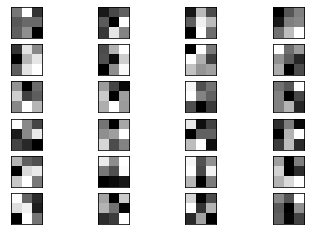

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

**Architecture**

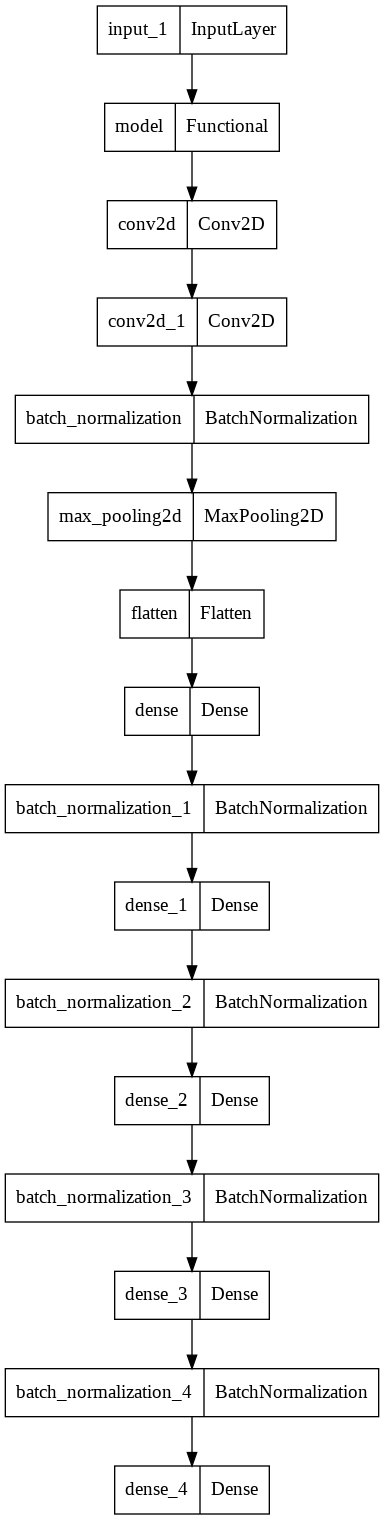

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [ ]:
model.layers[3]

**Activation**

In [ ]:
outputs = [layer.output for layer in model.layers[2:4]]
print(outputs)

vis_model = Model(model.input, outputs)


layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

[<KerasTensor: shape=(None, 54, 54, 128) dtype=float32 (created by layer 'conv2d')>, <KerasTensor: shape=(None, 52, 52, 128) dtype=float32 (created by layer 'conv2d_1')>]
Layers going to be used for visualization: 
['conv2d', 'conv2d_1']


In [ ]:
def show_random_sample(img):
    sample_image = np.array(img)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (224, 224))
    sample_label = 'test'

    sample_image_processed = np.expand_dims(sample_image, axis=0)
    #sample_image_processed = preprocessing_fn(sample_image_processed)
 
    activations = vis_model.predict(sample_image_processed)

    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    return activations

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
        plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


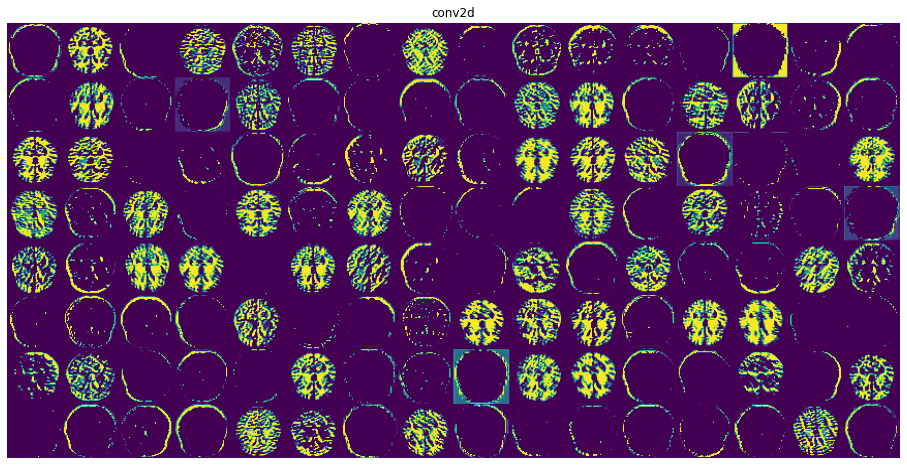

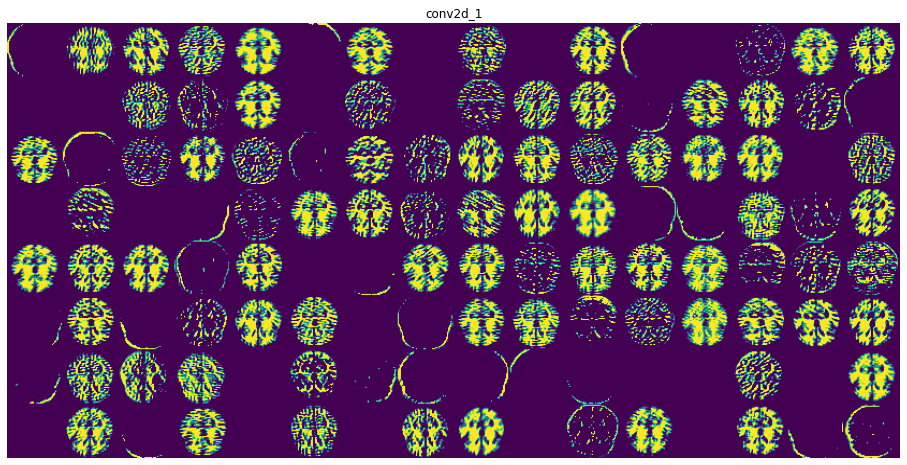

In [ ]:
activations = show_random_sample(img1)
visualize_intermediate_activations(activations=activations, 
                                   layer_names=layer_names)

**Grad-CAM**

In [ ]:
def make_gradcam_heatmap(img_array, model):
    last_conv_layer = model.layers[5]
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    
    classifier_layers = model.layers[-10:]

    
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for classifier_layer in classifier_layers:
        x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)

   
    with tf.GradientTape() as tape:
        
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from tensorflow import keras
p = np.expand_dims(cv2.resize(np.array(img1), (224, 224)),axis=0)

In [ ]:
import matplotlib.cm as cm

(1, 1, 224, 224, 3)


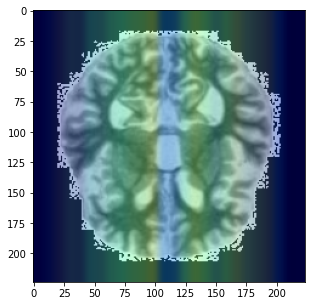

In [ ]:
def superimposed_cam(img):
    img_array = np.expand_dims(cv2.resize(img,(224,224)),axis=0)

    
    heatmap = make_gradcam_heatmap(
        img_array, model
    )
    print(np.expand_dims(img_array,axis=0).shape)
    
    img = img_array * 255

    
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img[0])
    
    return superimposed_img, heatmap

plt.figure(figsize=(5,5))

img, img_o = superimposed_cam(np.array(img1))
plt.imshow(img)


(1, 1, 224, 224, 3)


'cv2_imshow(np.concatenate((np.array(img), cv2.resize(np.array(img1),(224,224))), axis=1))\nimg, img_o = superimposed_cam(np.array(img2))\ncv2_imshow(np.concatenate((np.array(img), cv2.resize(np.array(img2),(224,224))), axis=1))\nimg, img_o = superimposed_cam(np.array(img3))\ncv2_imshow(np.concatenate((np.array(img), cv2.resize(np.array(img3),(224,224))), axis=1))\nimg, img_o = superimposed_cam(np.array(img4))\ncv2_imshow(np.concatenate((np.array(img), cv2.resize(np.array(img4),(224,224))), axis=1))'

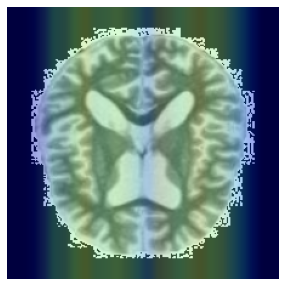

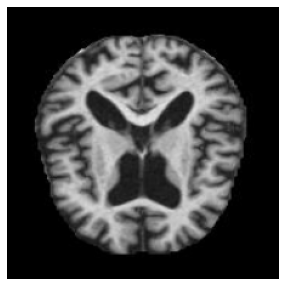

In [ ]:
plt.figure(figsize=(5,5))
img, img_o = superimposed_cam(np.array(img4))
#ax = plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(5,5))
plt.imshow(cv2.resize(np.array(img4),(224,224)))
plt.axis('off')